### Extraction of major peaks P-Q-R-S-T and relative time intervals

In [5]:
# Importing packages
import copy
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import signal
import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import keras
import keras_tuner as kt
from keras.utils import to_categorical
from keras.layers import Dense, Convolution1D, Convolution2D, MaxPool1D, Flatten, Dropout, AveragePooling1D
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.utils import resample
import warnings
import wfdb
import os
warnings.filterwarnings('ignore')

In [6]:
### Extract data from files
mitdb_list = [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202, 203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234]
NUM_FEATURES = 12

v_dataset_data = np.empty((1,NUM_FEATURES), dtype=float)
v_dataset_categ = np.empty(1, dtype=str)

for element in mitdb_list:

    print("##########")
    print("Current record: " + str(element))

    # Load all samples
    record = wfdb.rdrecord('src/mitdb/' + str(element))
    annotation = wfdb.rdann('src/mitdb/'+str(element), 'atr')

    # Convert annotations to useful ones
    # Read symbols and substitute them
    # Classes:  'N': Normal beat
    #           'S': Supraventricular premature
    #           'V': Premature ventricular contraction
    #           'F': Fusion of ventricular and normal beat
    #           'Q': Unclassifiable
    symbol_dict = { 'N':'N',
                    'S':'S', 'A':'S', 'a':'S', 'J':'S', 'e':'S', 'j':'S', 'x':'S',
                    'V':'V', 'L':'V', 'R':'V', 'E':'V', '[':'V', '!':'V', ']':'V',
                    'F':'F', 'f':'F',
                    'Q':'Q', '/':'Q', '|':'Q'}
    raw_ann_symbol = annotation.symbol.copy()
    raw_ann_sample = annotation.sample.copy()
    #raw_ann_symbol = [symbol_dict[key] if key in symbol_dict else key for key in raw_ann_symbol]
    raw_ann_symbol = [symbol_dict[key] if key in symbol_dict else 'Z' for key in raw_ann_symbol]

    # Delete non beat annotations
    if 'Z' in raw_ann_symbol:
        i_del = [i for i, x in enumerate(raw_ann_symbol) if x == 'Z']
        raw_ann_sample = np.delete(raw_ann_sample, i_del)
        raw_ann_symbol = np.delete(raw_ann_symbol, i_del)

    
    #del raw_ann_symbol[0]
    print(raw_ann_symbol)
    print(raw_ann_sample)
    print(len(raw_ann_symbol))
    print(len(raw_ann_sample))

    # Sampling frequency
    #FREQ_SAMPLE = 360
    #FREQ_SAMPLE = 1

    # Extract ECG data array
    v_data = record.p_signal
    v_data = v_data[:,0]

    # Define time array (Fs:360Hz)
    v_time = np.arange(0, v_data.size, 1, dtype=int)

    # Zeros array for x-axis
    axis_x = np.zeros_like(v_data)

    ### Signal filtering

    # Apply lowpass filter
    # Difference equation:
    # y(nT) = 2y(nT-T) - y(nT-2T) + x(nT) - 2x(nT-5T) + x(nT-10T)
    x = np.ones_like(v_data)*v_data
    for i in range(0,15):
        x[i] = 0
    y = np.zeros_like(v_data)
    for i in range(12, len(y)):
        y[i] = 2*y[i-1] - y[i-2] + x[i] - 2*x[i-5] + x[i-10]
    v_data_lp = np.copy(y)
    # Apply highpass filter to obtain bandpass
    # Difference equation:
    # y(nT) = -x(nT)/32 + x(nT-16T) - x(nT-17T) + x(nT-32T)/32 + y(nT-1T)
    x = np.copy(v_data_lp)
    y = np.zeros_like(v_data_lp)
    for i in range(35, len(y)):
        y[i] = -x[i]/32 + x[i-16] - x[i-17] + x[i-32]/32 + y[i-1]
    v_data_bp = np.copy(y)
    # Derivative filter
    # Difference equation:
    # y(nT) = 0.1(-x(nT-2T)) - 2x(nT-T) + 2x(nT+T) + x(nT+2T))
    x = np.copy(v_data_bp)
    y = np.zeros_like(v_data_bp)
    for i in range(2, len(y)-2):
        y[i] = 0.1*(-x[i-2] - 2*x[i-1] + 2*x[i+1] + x[i+2])
    v_data_der = np.copy(y)
    # Squaring filter
    # y(nT) = (x(nT)^2)
    v_data_sq = v_data_der*v_data_der

    # Moving average
    # Window size for moving averages
    WINDOW_TIME = 0.120 #ms
    WINDOW_NUM = int(360*WINDOW_TIME)
    v_data_avg = np.zeros_like(v_data)
    def moving_average(a, n=3):
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n
    tmp_avg = moving_average(v_data_sq, WINDOW_NUM)
    v_data_avg = np.pad(tmp_avg, (WINDOW_NUM-1,0), 'constant', constant_values=(tmp_avg[0],0))


    # Find R peaks
    # R peaks are extracted from the annotation array
    # R peaks are aligned to the original signal
    v_peaks_R_time = raw_ann_sample
    v_peaks_R_data_raw = np.ones_like(v_data)*-10
    for index in v_peaks_R_time:
        v_peaks_R_data_raw[index] = v_data[index]
    v_peaks_R_data = v_peaks_R_data_raw[v_peaks_R_data_raw != -10]


    ### Calculate RR times
    R_prev = 0
    RR_time = 0
    v_RR_time = np.zeros_like(v_peaks_R_time)
    for i in range(len(v_peaks_R_time)):
        if (v_peaks_R_time[i] != 0):
            RR_time = v_peaks_R_time[i] - R_prev
            R_prev = v_peaks_R_time[i]
            v_RR_time[i] = RR_time


    ### Find Q and S peaks
    v_peaks_Q_time = np.zeros_like(v_peaks_R_time)
    v_peaks_S_time = np.zeros_like(v_peaks_R_time)
    v_peaks_Q_data = np.zeros(len(v_peaks_R_time), dtype=float)
    v_peaks_S_data = np.zeros(len(v_peaks_R_time), dtype=float)
    # Find Q and S times
    for i in range(len(v_peaks_R_time)):
        # Find Q peak before current R time
        found_Q = False
        t = v_peaks_R_time[i]
        while found_Q is False:
            # Find a minumum
            if  ((v_data[t] <= v_data[t-1]) and (v_data[t] < v_data[t+1])):
                v_peaks_Q_time[i] = t
                found_Q = True
            t -= 1
        # Find S peak after current R time
        found_S = False
        t = v_peaks_R_time[i]
        while found_S is False:
            # Find a minumum
            if  ((v_data[t] <= v_data[t-1]) and (v_data[t] < v_data[t+1])):
                v_peaks_S_time[i] = t
                found_S = True
            if t==(len(v_data)-2):
                v_peaks_S_time[i] = t
                found_S = True
            else:
                t += 1
    # Find values at times of Q and S
    for i in range(len(v_peaks_R_data)):
        v_peaks_Q_data[i] = v_data[v_peaks_Q_time[i]]
        v_peaks_S_data[i] = v_data[v_peaks_S_time[i]]


    ### Define searching windows for P and T waves
    v_area_t_min = np.zeros_like(v_peaks_R_time)
    v_area_t_max = np.zeros_like(v_peaks_R_time)
    v_area_p_min = np.zeros_like(v_peaks_R_time)
    v_area_p_max = np.zeros_like(v_peaks_R_time)
    for i in range(len(v_peaks_R_time)):
        if (v_peaks_R_time[i] != 0):
            curr_time = v_peaks_R_time[i]
            # Calculate time window and convert it to index offset
            min_t = curr_time + int(0.12*v_RR_time[i])
            max_t = curr_time + int((0.57*v_RR_time[i]+0.060))
            min_p = curr_time - int(0.33*v_RR_time[i])
            max_p = curr_time - int((0.07*v_RR_time[i]+0.06))
            # Save area if window is not outside of signal
            if (max_t < v_peaks_R_time[-1]):
                for t in range(min_t, max_t):
                    v_area_t_min[i] = min_t
                    v_area_t_max[i] = max_t
            if (min_p > 0):
                for p in range(min_p, max_p):
                    v_area_p_min[i] = min_p
                    v_area_p_max[i] = max_p
    # Delete empty areas
    v_area_p_min = v_area_p_min[v_area_p_min != 0]
    v_area_p_max = v_area_p_max[v_area_p_max != 0]
    v_area_t_min = v_area_t_min[v_area_t_min != 0]
    v_area_t_max = v_area_t_max[v_area_t_max != 0]

            
    ### Apply Phasor Transform (see paper [3])
    # R_v values:
    #   0.001 for QRS
    #   0.1 for T-wave
    #   0.05 for P-wave
    # OFFSET is the shift between the raw data and the filtered data 
    OFFSET = 20
    v_phasor_qrs = np.arctan(v_data_bp/0.001)
    v_phasor_t = np.arctan(v_data_bp/0.1)
    v_phasor_p = np.arctan(v_data_bp/0.05)

    v_peaks_P_time = np.zeros_like(v_area_p_max)
    v_peaks_T_time = np.zeros_like(v_area_t_max)

    # Find max values of phasors inside searching windows
    for i in range(len(v_area_p_min)):
        v_peaks_P_time[i] = v_phasor_p[v_area_p_min[i]:v_area_p_max[i]].argmax(axis=0) + v_area_p_min[i] - OFFSET
    for i in range(len(v_area_t_min)):
        v_peaks_T_time[i] = v_phasor_t[v_area_t_min[i]:v_area_t_max[i]].argmax(axis=0) + v_area_t_min[i] - OFFSET
    v_peaks_P_data = np.zeros_like(v_peaks_P_time, dtype=float)
    v_peaks_T_data = np.zeros_like(v_peaks_T_time, dtype=float)
    for i in range(len(v_peaks_P_data)):
        v_peaks_P_data[i] = v_data[v_peaks_P_time[i]]
    for i in range(len(v_peaks_T_data)):
        v_peaks_T_data[i] = v_data[v_peaks_T_time[i]]

    ### Aggregate major points for each beat
    v_total_data = np.zeros(shape=(len(v_peaks_R_time),NUM_FEATURES))
    v_total_categ = np.empty(len(v_peaks_R_time), dtype=str)
    print("n P:" + str(len(v_peaks_P_time)) + "  n R:" + str(len(v_peaks_R_time)) + "  n T:" + str(len(v_peaks_T_time)) )
    print("n P:" + str(len(v_peaks_P_data)) + "  n R:" + str(len(v_peaks_R_data)) + "  n T:" + str(len(v_peaks_T_data)) )
    for i in range(1, len(v_peaks_R_time)-1):
        v_total_data[i, 0] = v_peaks_T_data[i-1] - v_peaks_R_data[i-1]
        v_total_data[i, 1] = v_peaks_P_data[i] - v_peaks_T_data[i-1]
        v_total_data[i, 2] = v_peaks_Q_data[i] - v_peaks_P_data[i]
        v_total_data[i, 3] = v_peaks_R_data[i] - v_peaks_Q_data[i]
        v_total_data[i, 4] = v_peaks_S_data[i] - v_peaks_R_data[i]
        v_total_data[i, 5] = v_peaks_T_data[i] - v_peaks_S_data[i]
        v_total_data[i, 6] = v_RR_time[i]
        v_total_data[i, 7] = v_peaks_T_time[i-1] - v_peaks_R_time[i-1]
        v_total_data[i, 8] = v_peaks_P_time[i-1] - v_peaks_T_time[i]
        v_total_data[i, 9] = v_peaks_R_time[i] - v_peaks_P_time[i]
        v_total_data[i, 10] = v_peaks_S_time[i] - v_peaks_T_time[i]
        v_total_data[i, 11] = v_peaks_T_time[i] - v_peaks_R_time[i]

        v_total_categ[i] = raw_ann_symbol[i]
    # Delete empty data
    v_total_data = v_total_data[v_total_categ != '']
    v_total_categ = v_total_categ[v_total_categ != '']
    
    # Copy results to dataset variables
    v_dataset_data = np.append(v_dataset_data, v_total_data, axis=0)
    v_dataset_categ = np.append(v_dataset_categ, v_total_categ)

# Delete first element (empty)
v_dataset_data = v_dataset_data[1:,:]
v_dataset_categ = v_dataset_categ[1:]

print(v_dataset_categ)
print(v_dataset_data)


##########
Current record: 100
['N' 'N' 'N' ... 'N' 'N' 'N']
[    77    370    662 ... 649484 649734 649991]
2273
2273
n P:2273  n R:2273  n T:2272
n P:2273  n R:2273  n T:2272
##########
Current record: 101
['N' 'N' 'N' ... 'N' 'N' 'N']
[    83    396    711 ... 649004 649372 649751]
1869
1869
n P:1869  n R:1869  n T:1868
n P:1869  n R:1869  n T:1868
##########
Current record: 102
['Q' 'Q' 'Q' ... 'Q' 'Q' 'Q']
[   136    410    697 ... 649244 649553 649852]
2187
2187
n P:2187  n R:2187  n T:2186
n P:2187  n R:2187  n T:2186
##########
Current record: 103
['N' 'N' 'N' ... 'N' 'N' 'N']
[   265    575    876 ... 649195 649534 649875]
2084
2084
n P:2084  n R:2084  n T:2083
n P:2084  n R:2084  n T:2083
##########
Current record: 104
['Q' 'Q' 'Q' ... 'Q' 'Q' 'Q']
[    73    316    615 ... 649300 649580 649876]
2229
2229
n P:2229  n R:2229  n T:2228
n P:2229  n R:2229  n T:2228
##########
Current record: 105
['N' 'N' 'N' ... 'N' 'N' 'N']
[   197    459    708 ... 649221 649471 649740]
2602
2

In [7]:
v_dataset_data_bk = np.copy(v_dataset_data)
v_dataset_categ_bk = np.copy(v_dataset_categ)

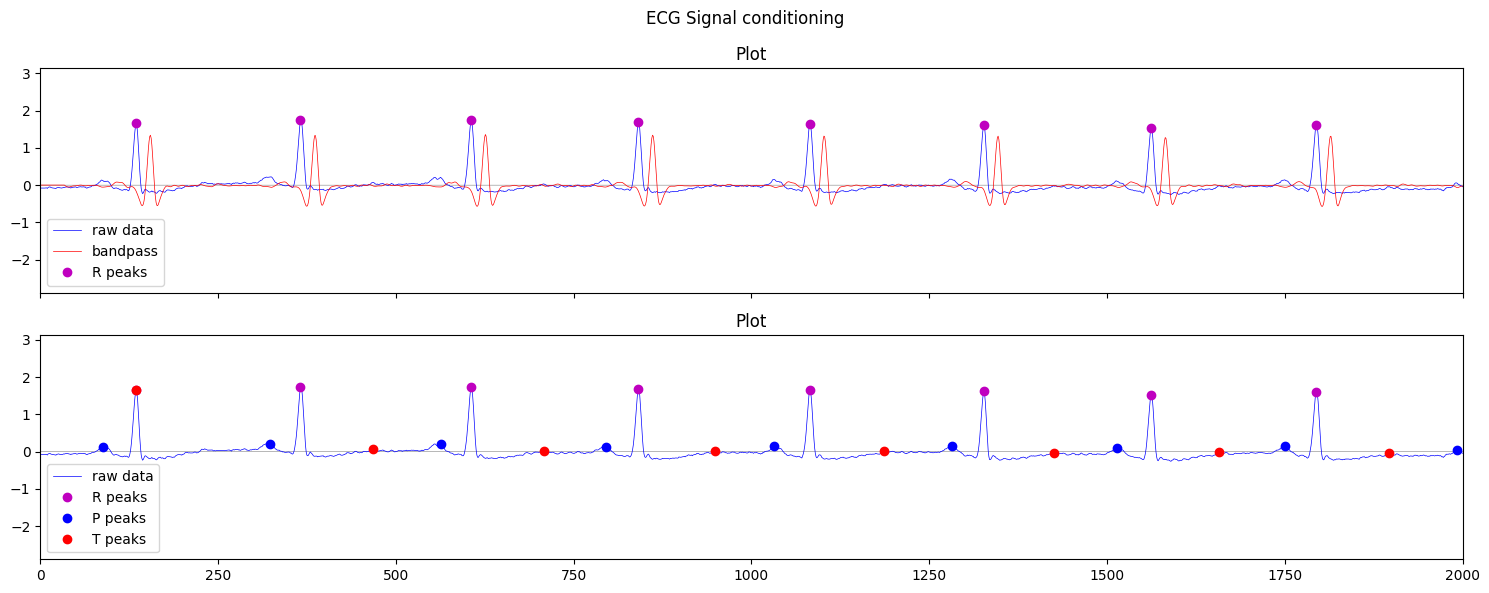

In [8]:
# Plotting window
X_MIN = 0.0
X_MAX = 2000
N_ROW = 2

n = 0
# Create plots
fig, axs = plt.subplots(N_ROW, 1, sharex=True)
fig.set_size_inches(15, 3*N_ROW)
fig.suptitle("ECG Signal conditioning")
axs[n].set_xlim(X_MIN, X_MAX)

# First plot
axs[n].title.set_text('Plot')
axs[n].plot(v_time, axis_x, linewidth=0.2, color="black")
axs[n].plot(v_time, v_data, 'b', label="raw data", linewidth=0.5)
axs[n].plot(v_time, v_data_bp/20, 'r', label="bandpass", linewidth=0.5)
axs[n].plot(v_peaks_R_time, v_peaks_R_data, 'mo', label="R peaks", linewidth=0.5)
axs[n].legend()
n += 1

# Second plot
axs[n].title.set_text('Plot')
axs[n].plot(v_time, axis_x, linewidth=0.2, color="black")
axs[n].plot(v_time, v_data, 'b', label="raw data", linewidth=0.5)
axs[n].plot(v_peaks_R_time, v_peaks_R_data, 'mo', label="R peaks", linewidth=0.5)
axs[n].plot(v_peaks_P_time, v_peaks_P_data, 'bo', label="P peaks", linewidth=0.5)
axs[n].plot(v_peaks_T_time, v_peaks_T_data, 'ro', label="T peaks", linewidth=0.5)
axs[n].legend()
n += 1

plt.tight_layout()
plt.show()

### NN training

In [9]:
# Copy from backup data
dataset_categ = np.copy(v_dataset_categ_bk)
dataset_data = np.copy(v_dataset_data_bk)

# Convert symbols to numbers
category_dict = {   'N':0,
                    'S':1,
                    'V':2,
                    'F':3,
                    'Q':4}
dataset_categ = [category_dict[key] if key in category_dict else 'Z' for key in dataset_categ]

# Divide data into sets
DATA_SPLIT = 0.2
SEED = 1029384756
set_train, x_valid, target_train, y_valid = train_test_split(dataset_data, dataset_categ, test_size=DATA_SPLIT, random_state=SEED)
x_train, x_test, y_train, y_test = train_test_split(set_train, target_train, test_size=DATA_SPLIT, random_state=SEED)

y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_valid=to_categorical(y_valid)



In [10]:
# Print how many beats are in each set
tot_y_train = np.sum(y_train, axis=0)
tot_y_test = np.sum(y_test, axis=0)
tot_y_valid = np.sum(y_valid, axis=0)
tot_y_all = tot_y_train + tot_y_test + tot_y_valid
print(tot_y_train)
print(tot_y_test)
print(tot_y_valid)
print(tot_y_all)

[48085.  2062. 14639.  1147.  4599.]
[11954.   522.  3784.   280.  1093.]
[14945.   633.  4614.   357.  1493.]
[74984.  3217. 23037.  1784.  7185.]


In [12]:
# Network Architecture Search with Tensorflow

def build_model(hp):
  model = keras.Sequential()
  
  # Standard input layer
  model.add(keras.layers.Input(shape=((x_train[0].shape[0],1)), name='inputs_cnn'))
  # Tune whether to use convolutional layer
  #if hp.Boolean("conv_1"):
  #  model.add(keras.layers.Convolution1D( filters=hp.Int("filters_1", min_value=1, max_value=5, step=1), 
  #                                        kernel_size=hp.Int("kernel_size_1", min_value=3, max_value=7, step=2),
  #                                        strides=1, padding="same", activation='relu'))
  #if hp.Boolean("maxpool_1"):
  #  model.add(keras.layers.MaxPool1D(pool_size=hp.Int("pool_size_1", min_value=1, max_value=6, step=1)))
  #if hp.Boolean("conv_2"):
  #  model.add(keras.layers.Convolution1D( filters=hp.Int("filters_2", min_value=1, max_value=5, step=1), 
  #                                        kernel_size=hp.Int("kernel_size_2", min_value=3, max_value=7, step=2),
  #                                        strides=1, padding="same", activation='relu'))
  #if hp.Boolean("maxpool_2"):
  #  model.add(keras.layers.MaxPool1D(pool_size=hp.Int("pool_size_2", min_value=1, max_value=6, step=1)))
  # Flatten before dense layers
  model.add(keras.layers.Flatten())
  # Tune the number of units in the first Dense layer
  if hp.Boolean("dense_1"):
    model.add(keras.layers.Dense( units=hp.Int("units_1", min_value=5, max_value=20, step=1),
                                  activation="relu"))
  if hp.Boolean("dense_2"):
    model.add(keras.layers.Dense( units=hp.Int("units_2", min_value=5, max_value=20, step=1),
                                  activation="relu"))
  model.add(keras.layers.Dense(5, activation='softmax', name='main_output'))
  # Tune the learning rate 
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
  )
  return model

build_model(kt.HyperParameters())

tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)


tuner.search(x_train, y_train, epochs=4, validation_data=(x_valid, y_valid))


Trial 20 Complete [00h 00m 26s]
val_accuracy: 0.7229153215885162

Best val_accuracy So Far: 0.7483213841915131
Total elapsed time: 00h 08m 31s


In [13]:
tuner.results_summary()

Results summary
Results in my_dir\helloworld
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
dense_1: False
dense_2: True
lr: 0.0032029709329172997
units_1: 5
units_2: 5
Score: 0.7483213841915131

Trial 04 summary
Hyperparameters:
dense_1: True
dense_2: False
lr: 0.008263646698419431
units_1: 9
units_2: 9
Score: 0.7306959629058838

Trial 18 summary
Hyperparameters:
dense_1: False
dense_2: True
lr: 0.0006346630548574778
units_1: 6
units_2: 9
Score: 0.7267262637615204

Trial 15 summary
Hyperparameters:
dense_1: True
dense_2: False
lr: 0.0011674312709210404
units_1: 6
units_2: 7
Score: 0.723278284072876

Trial 19 summary
Hyperparameters:
dense_1: False
dense_2: True
lr: 0.0003087530450909568
units_1: 7
units_2: 7
Score: 0.7229153215885162

Trial 06 summary
Hyperparameters:
dense_1: False
dense_2: False
lr: 0.008153809124911116
units_1: 9
units_2: 10
Score: 0.7199437320232391

Trial 11 summary
Hyperparameters:
dense_1: True
dense_2:

In [14]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

model = best_model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_output (Dense)             │ (None, 5)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95 (380.00 B)

 Trainable params: 95 (380.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Training parameters
EPOCH_NUM = 25
BATCH_SIZE = 32

# Train model
history=model.fit(x_train, y_train, epochs=EPOCH_NUM, batch_size=BATCH_SIZE, validation_data=(x_valid,y_valid))
#history=model.fit(x_train, y_train, epochs=EPOCH_NUM, batch_size=BATCH_SIZE, validation_data=(x_valid,y_valid), callbacks=[tensorboard_callback])


Epoch 1/25
2205/2205 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7438 - loss: 0.8003 - val_accuracy: 0.7695 - val_loss: 0.7713
Epoch 2/25
2205/2205 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7511 - loss: 0.7764 - val_accuracy: 0.7486 - val_loss: 0.7646
Epoch 3/25
2205/2205 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7524 - loss: 0.7664 - val_accuracy: 0.7615 - val_loss: 0.7407
Epoch 4/25
2205/2205 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7507 - loss: 0.7410 - val_accuracy: 0.7647 - val_loss: 0.7214
Epoch 5/25
2205/2205 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7609 - loss: 0.7232 - val_accuracy: 0.7689 - val_loss: 0.7197
Epoch 6/25
2205/2205 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7657 - loss: 0.7148 - val_accuracy: 0.7739 - val_loss: 0.7018
Epoch 7/25
2205/2205 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7640 - loss: 0.7150 - val_accuracy: 0.7630 - val_loss: 0.7328
Epoch 8/25
2205/2205 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7732 - loss: 0.6984 - 

In [19]:
y_prediction = model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis = 1)
y_test_pred = np.argmax(y_test, axis=1)


# Create confusion matrix and normalize it over predicted (columns)
#result = confusion_matrix(y_test_pred, y_prediction , normalize='pred')
result = confusion_matrix(y_test_pred, y_prediction , normalize='true')
#result = confusion_matrix(y_test_pred, y_prediction , normalize='all')
#result = confusion_matrix(y_test_pred, y_prediction)
classes = [0,1,2,3,4]
#result_norm = np.around(result, 4)
result_norm = result
mat_result = pd.DataFrame(result_norm,
                     index = classes, 
                     columns = classes)

total_pred = np.trace(result) / 5

print('Confusion matrix')
print(mat_result)
print()
print('Average accuracy')
print(total_pred)

552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Confusion matrix
          0         1         2    3         4
0  0.923540  0.000084  0.074536  0.0  0.001840
1  0.534483  0.040230  0.404215  0.0  0.021073
2  0.382664  0.000529  0.519556  0.0  0.097252
3  0.732143  0.000000  0.221429  0.0  0.046429
4  0.166514  0.000000  0.251601  0.0  0.581885

Average accuracy
0.41304217379126795


In [20]:
print(len(x_test))
print(len(y_test))
print(len(y_prediction))
print(result)

17633
17633
17633
[[9.23540238e-01 8.36540070e-05 7.45357203e-02 0.00000000e+00
  1.84038815e-03]
 [5.34482759e-01 4.02298851e-02 4.04214559e-01 0.00000000e+00
  2.10727969e-02]
 [3.82663848e-01 5.28541226e-04 5.19556025e-01 0.00000000e+00
  9.72515856e-02]
 [7.32142857e-01 0.00000000e+00 2.21428571e-01 0.00000000e+00
  4.64285714e-02]
 [1.66514181e-01 0.00000000e+00 2.51601098e-01 0.00000000e+00
  5.81884721e-01]]


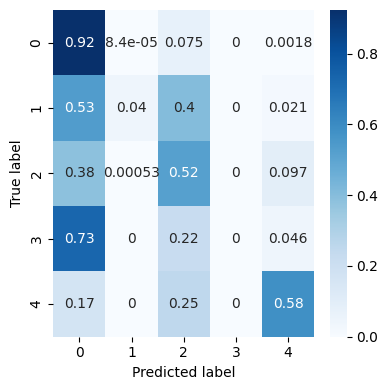

In [21]:
figure = plt.figure(figsize=(4, 4))
sns.heatmap(mat_result, annot=True,cmap=plt.cm.Blues)
#plt.title(model_name)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
#plt.savefig(log_dir + '/' + model_name + '.png', pad_inches=0.1)
plt.show()